In [10]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.fx as fx



In [11]:
class FeaturesLinear(torch.nn.Module):

    def __init__(self, field_dims, output_dim=1):
        super().__init__()
        self.fc = torch.nn.Embedding(sum(field_dims), output_dim)
        self.bias = torch.nn.Parameter(torch.zeros((output_dim,)))
        # self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int64)
        self.offsets = torch.as_tensor(np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int64))


    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        # x = x + x.new_tensor(self.offsets).unsqueeze(0)
        x = x + self.offsets
        return torch.sum(self.fc(x), dim=1) + self.bias


class FeaturesEmbedding(torch.nn.Module):

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        # self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int64)
        self.offsets = torch.as_tensor(np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int64))
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        # x = x + x.new_tensor(self.offsets).unsqueeze(0)
        x = x + self.offsets
        return self.embedding(x)


In [12]:
class FactorizationMachine(torch.nn.Module):

    def __init__(self, reduce_sum=True):
        super().__init__()
        self.reduce_sum = reduce_sum

    def forward(self, x):
        """
        :param x: Float tensor of size ``(batch_size, num_fields, embed_dim)``
        """
        square_of_sum = torch.sum(x, dim=1) ** 2
        sum_of_square = torch.sum(x ** 2, dim=1)
        ix = square_of_sum - sum_of_square
        if self.reduce_sum:
            ix = torch.sum(ix, dim=1, keepdim=True)
        return 0.5 * ix

In [13]:
class InnerProductNetworkV2(torch.nn.Module):
    def __init__(self, num_fields):
        super().__init__()
        self.interaction_units = int(num_fields * (num_fields - 1) / 2)
        self.triu_mask = nn.Parameter(torch.triu(torch.ones(num_fields, num_fields), 1).bool(),
                                    requires_grad=False) 
    def forward(self, feature_emb):
        inner_product_matrix = torch.bmm(feature_emb, feature_emb.transpose(1, 2))
        triu_values = torch.masked_select(inner_product_matrix, self.triu_mask)
        return triu_values.view(-1, self.interaction_units)


class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, embed_dims, dropout, output_layer=True):
        super().__init__()
        layers = list()
        for embed_dim in embed_dims:
            layers.append(torch.nn.Linear(input_dim, embed_dim))
            # layers.append(torch.nn.BatchNorm1d(embed_dim))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(p=dropout))
            input_dim = embed_dim
        if output_layer:
            layers.append(torch.nn.Linear(input_dim, 1))
        self.mlp = torch.nn.Sequential(*layers)
    def forward(self, x):
        """
        :param x: Float tensor of size ``(batch_size, embed_dim)``
        """
        return self.mlp(x)

In [14]:
class FactorizationMachineModel(torch.nn.Module):
    """
    A pytorch implementation of Factorization Machine.

    Reference:
        S Rendle, Factorization Machines, 2010.
    """

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.linear = FeaturesLinear(field_dims)
        self.fm = FactorizationMachine(reduce_sum=True)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = self.linear(x) + self.fm(self.embedding(x))
        return torch.sigmoid(x.squeeze(1))

In [15]:
class ProductNeuralNetworkModel(torch.nn.Module):
    """
    A pytorch implementation of inner/outer Product Neural Network.
    Reference:
        Y Qu, et al. Product-based Neural Networks for User Response Prediction, 2016.
    """
    # def get_inputs(self, inputs):
    #     X_dict = dict()
    #     # X_dict[0] = inputs[:, 0:13]
    #     # X_dict[1] = inputs[:,13:26]
    #     for feature in range(self.field_num):
    #         X_dict[feature] = inputs[:, feature]
    #     # return X_dict
    def __init__(self, field_dims, embed_dim, mlp_dims, dropout, method='inner'):
        super().__init__()
        self.field_num = len(field_dims)
        self.field_dims = field_dims
        num_fields = len(field_dims)
        if method == 'inner':
            self.pn = InnerProductNetworkV2(num_fields)
        # elif method == 'outer':
        #     self.pn = OuterProductNetwork(num_fields, embed_dim)
        # else:
        #     raise ValueError('unknown product type: ' + method)
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.linear = FeaturesLinear(field_dims, embed_dim)
        self.embed_output_dim = num_fields * embed_dim
        self.mlp = MultiLayerPerceptron(num_fields * (num_fields - 1) // 2 + self.embed_output_dim, mlp_dims, dropout)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        embed_x = self.embedding(x)
        cross_term = self.pn(embed_x)
        x = torch.cat([embed_x.view(-1, self.embed_output_dim), cross_term], dim=1)
        x = self.mlp(x)
        return torch.sigmoid(x.squeeze(1))

In [74]:
model = FactorizationMachineModel([10 for _ in range(10)],8)

In [9]:
graph = fx.symbolic_trace(model)


NameError: name 'model' is not defined

In [76]:
graph.graph.print_tabular()


opcode         name                 target                                                      args                      kwargs
-------------  -------------------  ----------------------------------------------------------  ------------------------  ---------------------------
placeholder    x                    x                                                           ()                        {}
get_attr       linear_offsets       linear.offsets                                              ()                        {}
call_function  add                  <built-in function add>                                     (x, linear_offsets)       {}
call_module    linear_fc            linear.fc                                                   (add,)                    {}
call_function  sum_1                <built-in method sum of type object at 0x7f1e63881760>      (linear_fc,)              {'dim': 1}
get_attr       linear_bias          linear.bias                                         

In [9]:
print(graph.code)




def forward(self, x):
    linear_offsets = self.linear.offsets
    new_tensor = x.new_tensor(linear_offsets);  linear_offsets = None
    unsqueeze = new_tensor.unsqueeze(0);  new_tensor = None
    add = x + unsqueeze;  unsqueeze = None
    linear_fc = self.linear.fc(add);  add = None
    sum_1 = torch.sum(linear_fc, dim = 1);  linear_fc = None
    linear_bias = self.linear.bias
    add_1 = sum_1 + linear_bias;  sum_1 = linear_bias = None
    embedding_offsets = self.embedding.offsets
    new_tensor_1 = x.new_tensor(embedding_offsets);  embedding_offsets = None
    unsqueeze_1 = new_tensor_1.unsqueeze(0);  new_tensor_1 = None
    add_2 = x + unsqueeze_1;  x = unsqueeze_1 = None
    embedding_embedding = self.embedding.embedding(add_2);  add_2 = None
    sum_2 = torch.sum(embedding_embedding, dim = 1)
    pow_1 = sum_2 ** 2;  sum_2 = None
    pow_2 = embedding_embedding ** 2;  embedding_embedding = None
    sum_3 = torch.sum(pow_2, dim = 1);  pow_2 = None
    sub = pow_1 - sum_3;  pow

In [10]:
print(graph.graph)

graph():
    %x : [num_users=4] = placeholder[target=x]
    %linear_offsets : [num_users=1] = get_attr[target=linear.offsets]
    %new_tensor : [num_users=1] = call_method[target=new_tensor](args = (%x, %linear_offsets), kwargs = {})
    %unsqueeze : [num_users=1] = call_method[target=unsqueeze](args = (%new_tensor, 0), kwargs = {})
    %add : [num_users=1] = call_function[target=operator.add](args = (%x, %unsqueeze), kwargs = {})
    %linear_fc : [num_users=1] = call_module[target=linear.fc](args = (%add,), kwargs = {})
    %sum_1 : [num_users=1] = call_function[target=torch.sum](args = (%linear_fc,), kwargs = {dim: 1})
    %linear_bias : [num_users=1] = get_attr[target=linear.bias]
    %add_1 : [num_users=1] = call_function[target=operator.add](args = (%sum_1, %linear_bias), kwargs = {})
    %embedding_offsets : [num_users=1] = get_attr[target=embedding.offsets]
    %new_tensor_1 : [num_users=1] = call_method[target=new_tensor](args = (%x, %embedding_offsets), kwargs = {})
    %unsqu

In [27]:
import operator


In [44]:
traced_graph = torch.fx.symbolic_trace(model)


In [56]:
module_path, _, attr_name = "linear.offsets".rpartition(".")

In [57]:
mod = graph.get_submodule(module_path)

In [58]:
mod

Module(
  (fc): Embedding(100, 1)
)

In [59]:
attr = getattr(mod, attr_name, None)

In [60]:
attr.data

tensor([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

In [70]:
for i in graph.graph.nodes:
  print(f"{i},{i.name}:{i.target}:{i.args}:{i.kwargs}")

x:x:x:():{}
linear_offsets:linear_offsets:linear.offsets:():{}
new_tensor:new_tensor:new_tensor:(x, linear_offsets):{}
unsqueeze:unsqueeze:unsqueeze:(new_tensor, 0):{}
add:add:<built-in function add>:(x, unsqueeze):{}
linear_fc:linear_fc:linear.fc:(add,):{}
sum_1:sum_1:<built-in method sum of type object at 0x7f1e63881760>:(linear_fc,):{'dim': 1}
linear_bias:linear_bias:linear.bias:():{}
add_1:add_1:<built-in function add>:(sum_1, linear_bias):{}
embedding_offsets:embedding_offsets:embedding.offsets:():{}
new_tensor_1:new_tensor_1:new_tensor:(x, embedding_offsets):{}
unsqueeze_1:unsqueeze_1:unsqueeze:(new_tensor_1, 0):{}
add_2:add_2:<built-in function add>:(x, unsqueeze_1):{}
embedding_embedding:embedding_embedding:embedding.embedding:(add_2,):{}
sum_2:sum_2:<built-in method sum of type object at 0x7f1e63881760>:(embedding_embedding,):{'dim': 1}
pow_1:pow_1:<built-in function pow>:(sum_2, 2):{}
pow_2:pow_2:<built-in function pow>:(embedding_embedding, 2):{}
sum_3:sum_3:<built-in method

In [37]:
def transform(m: torch.nn.Module,
              tracer_class : type = fx.Tracer) -> torch.nn.Module:
    graph : fx.Graph = tracer_class().trace(m)
    # FX represents its Graph as an ordered list of
    # nodes, so we can iterate through them.
    for node in graph.nodes:
        # Checks if we're calling a function (i.e:
        # torch.add)
        if node.op == 'call_function':
            # The target attribute is the function
            # that call_function calls.
            if node.target == operator.add:
                node.target = operator.add

    graph.lint() # Does some checks to make sure the
                 # Graph is well-formed.

    return fx.GraphModule(m, graph)

In [38]:
import torch.onnx
newGraph = transform(model)

In [39]:
newGraph.eval()

GraphModule(
  (linear): Module(
    (fc): Embedding(100, 1)
  )
  (embedding): Module(
    (embedding): Embedding(100, 8)
  )
)

In [40]:
output_onnx = "my_model.onnx"

torch.onnx.export(
    newGraph,  # 模型
    torch.zeros((4096,10),dtype=torch.int64),  # 模型的输入 (注意：需要是一个Tensor并且维度必须正确)
    output_onnx,  # 输出文件名
    # export_params=True,  # 如果设置为True，则导出参数；否则，仅导出计算图
    # opset_version=10,  # ONNX版本
    # do_constant_folding=True,  # 是否执行常量折叠优化
)

<eval_with_key>.2 from /tmp/ipykernel_118810/2813138532.py:15 in forward:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  new_tensor = x.new_tensor(linear_offsets);  linear_offsets = None
<eval_with_key>.2 from /tmp/ipykernel_118810/2813138532.py:15 in forward:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  new_tensor_1 = x.new_tensor(embedding_offsets);  embedding_offsets = None


In [64]:
class M(torch.nn.Module):
    def forward(self, x, y):
        return x + y, torch.add(x, y), x.add(y)

In [101]:
class S(torch.nn.Module):
    def forward(self, x, y):
        return x - y, torch.sub(x, y), x.sub(y)

In [100]:
class Mul(torch.nn.Module):
    def forward(self, x, y):
        return x * y, torch.mul(x, y), x.mul(y),torch.multiply(x,y), x.multiple(y)

In [99]:
class pow(torch.nn.Module):
    def forward(self, x):
        return x**2,torch.pow(x,2),x.pow(2)

In [66]:
traced = torch.fx.symbolic_trace(M())


In [68]:
print(traced.graph)

graph():
    %x : [num_users=3] = placeholder[target=x]
    %y : [num_users=3] = placeholder[target=y]
    %add : [num_users=1] = call_function[target=operator.add](args = (%x, %y), kwargs = {})
    %add_1 : [num_users=1] = call_function[target=torch.add](args = (%x, %y), kwargs = {})
    %add_2 : [num_users=1] = call_method[target=add](args = (%x, %y), kwargs = {})
    return (add, add_1, add_2)


In [18]:
pnn_model = ProductNeuralNetworkModel([10 for _ in range(10)],8,[400,400,400],0.1)

In [19]:
pnn_graph = fx.symbolic_trace(pnn_model)
pnn_graph.graph.print_tabular()

opcode         name                 target                                                            args                              kwargs
-------------  -------------------  ----------------------------------------------------------------  --------------------------------  ----------
placeholder    x                    x                                                                 ()                                {}
get_attr       embedding_offsets    embedding.offsets                                                 ()                                {}
call_function  add                  <built-in function add>                                           (x, embedding_offsets)            {}
call_module    embedding_embedding  embedding.embedding                                               (add,)                            {}
call_method    transpose            transpose                                                         (embedding_embedding, 1, 2)       {}
call_function  

In [94]:
torch.save(M(), "M.pth")


In [96]:
model = torch.load("M.pth")

In [97]:
m_graph = fx.symbolic_trace(model)
m_graph.graph.print_tabular()

opcode         name    target                                                  args                    kwargs
-------------  ------  ------------------------------------------------------  ----------------------  --------
placeholder    x       x                                                       ()                      {}
placeholder    y       y                                                       ()                      {}
call_function  add     <built-in function add>                                 (x, y)                  {}
call_function  add_1   <built-in method add of type object at 0x7f1e63881760>  (x, y)                  {}
call_method    add_2   add                                                     (x, y)                  {}
output         output  output                                                  ((add, add_1, add_2),)  {}


In [102]:
m_graph = fx.symbolic_trace(S())
m_graph.graph.print_tabular()

opcode         name    target                                                  args                    kwargs
-------------  ------  ------------------------------------------------------  ----------------------  --------
placeholder    x       x                                                       ()                      {}
placeholder    y       y                                                       ()                      {}
call_function  sub     <built-in function sub>                                 (x, y)                  {}
call_function  sub_1   <built-in method sub of type object at 0x7f1e63881760>  (x, y)                  {}
call_method    sub_2   sub                                                     (x, y)                  {}
output         output  output                                                  ((sub, sub_1, sub_2),)  {}


In [119]:
m_graph = fx.symbolic_trace(Mul())
m_graph.graph.print_tabular()

opcode         name      target                                                       args                                        kwargs
-------------  --------  -----------------------------------------------------------  ------------------------------------------  --------
placeholder    x         x                                                            ()                                          {}
placeholder    y         y                                                            ()                                          {}
call_function  mul       <built-in function mul>                                      (x, y)                                      {}
call_function  mul_1     <built-in method mul of type object at 0x7f1e63881760>       (x, y)                                      {}
call_method    mul_2     mul                                                          (x, y)                                      {}
call_function  multiply  <built-in method multiply of type 

In [120]:
mga = m_graph.graph

In [121]:
mga._root.next

x

In [122]:
mga._root.next.next

y

In [114]:
m_graph = fx.symbolic_trace(pow())
m_graph.graph.print_tabular()

opcode         name    target                                                  args                      kwargs
-------------  ------  ------------------------------------------------------  ------------------------  --------
placeholder    x       x                                                       ()                        {}
call_function  pow_1   <built-in function pow>                                 (x, 2)                    {}
call_function  pow_2   <built-in method pow of type object at 0x7f1e63881760>  (x, 2)                    {}
call_method    pow_3   pow                                                     (x, 2)                    {}
output         output  output                                                  ((pow_1, pow_2, pow_3),)  {}


In [115]:
mga = m_graph.graph

In [118]:
mga._root.next.next.next

pow_2

In [105]:
ga = pnn_graph.graph

In [107]:
ga.print_tabular()

opcode         name                 target                                                            args                              kwargs
-------------  -------------------  ----------------------------------------------------------------  --------------------------------  ----------
placeholder    x                    x                                                                 ()                                {}
get_attr       embedding_offsets    embedding.offsets                                                 ()                                {}
call_function  add                  <built-in function add>                                           (x, embedding_offsets)            {}
call_module    embedding_embedding  embedding.embedding                                               (add,)                            {}
call_method    transpose            transpose                                                         (embedding_embedding, 1, 2)       {}
call_function  

In [109]:
print(ga._root)

In [125]:
print(ga._root.next.next.next.next.next.args)

(embedding_embedding, 1, 2)


In [126]:
t = ga._root.next.next.next.next.next.args

In [132]:
type(t[0])

torch.fx.node.Node

In [129]:
from graphviz import Digraph


In [135]:
def draw(graph):
    dot = Digraph(comment='graph')
    root = graph._root
    cur = root._next
    while cur is not root:
        if not cur._erased:
            dot.node(cur.name,cur.name,style='filled',
                    shape='box',
                    align='left',
                    fontsize='10',
                    ranksep='0.1',
                    height='0.2',
                    fontname='monospace',fillcolor='Orange')
            for arg in cur.args:
                if isinstance(arg,torch.fx.node.Node):
                    dot.edge(arg.name,cur.name)
                if isinstance(arg,list):
                    for item in arg:
                        dot.edge(item.name,cur.name)
        cur = cur._next
    return dot

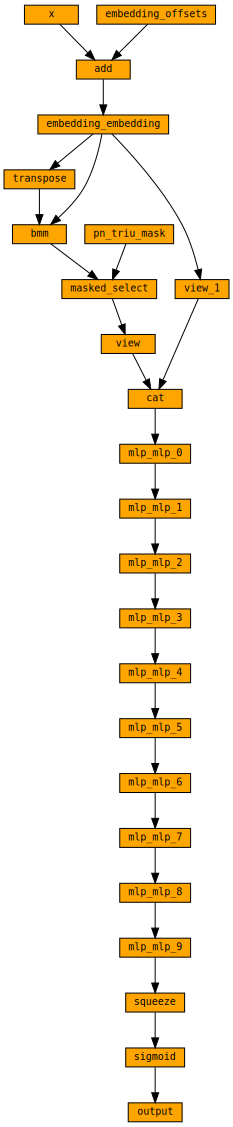

In [137]:
draw(ga)

In [141]:
def get_dict(graph):
  name_dict = {}
  root = graph._root
  cur = root._next
  while cur is not root:
      if not cur._erased:
        name_dict[cur.name] = cur
      cur = cur._next
  return name_dict

In [142]:
name_dict = get_dict(ga)

In [143]:
name_dict

{'x': x,
 'embedding_offsets': embedding_offsets,
 'add': add,
 'embedding_embedding': embedding_embedding,
 'transpose': transpose,
 'bmm': bmm,
 'pn_triu_mask': pn_triu_mask,
 'masked_select': masked_select,
 'view': view,
 'view_1': view_1,
 'cat': cat,
 'mlp_mlp_0': mlp_mlp_0,
 'mlp_mlp_1': mlp_mlp_1,
 'mlp_mlp_2': mlp_mlp_2,
 'mlp_mlp_3': mlp_mlp_3,
 'mlp_mlp_4': mlp_mlp_4,
 'mlp_mlp_5': mlp_mlp_5,
 'mlp_mlp_6': mlp_mlp_6,
 'mlp_mlp_7': mlp_mlp_7,
 'mlp_mlp_8': mlp_mlp_8,
 'mlp_mlp_9': mlp_mlp_9,
 'squeeze': squeeze,
 'sigmoid': sigmoid,
 'output': output}

In [144]:
embedding_offsets  = name_dict['embedding_offsets']

In [146]:
type(embedding_offsets)

torch.fx.node.Node

# 如何在fx中获取get_attr
- 获取到target
- 使用 graphModule的get_submodule方法获取到子module
- 对子module使用getattr获取参数

In [155]:
target = embedding_offsets.target

In [156]:
target

'embedding.offsets'

In [157]:
module_path,_,attr_name = target.rpartition(".")

In [159]:
mod = pnn_graph.get_submodule(module_path)

In [160]:
attr = getattr(mod,attr_name,None)

In [161]:
attr.data

tensor([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

# 如何获取 callModule的参数

In [20]:
mod = pnn_graph.get_submodule('mlp')

In [21]:
type(mod)

torch.nn.modules.module.Module

In [22]:
mod2 = getattr(pnn_graph,'mlp')

In [23]:
type(mod2)

torch.nn.modules.module.Module

In [175]:
dir(mod)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_se

In [176]:
attr = getattr(mod,'mlp',None)

In [177]:
dir(attr)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_se

In [178]:
attr = getattr(attr,'0',None)

In [172]:
dir(attr)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_per

In [180]:
attr.weight.shape

torch.Size([400, 125])

In [183]:
attr.bias.shape

torch.Size([400])

In [37]:
target_name = "mlp.mlp.0"
target_name_list = target_name.split(".")
target_name_list

['mlp', 'mlp', '0']

In [38]:
mod = pnn_graph
for name in target_name_list:
  mod = getattr(mod,name)

In [39]:
weight = mod.weight
bias = mod.bias

In [40]:
weight.shape

torch.Size([400, 125])

In [41]:
bias.shape

torch.Size([400])